# *Monod* model selection: fit to liver cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['brain_5k_v3','brain_nuc_5k_v3']

# cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = dataset_meta 
raw_data_locations = dataset_meta
# dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)




In [4]:
# loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[0]+'.loom' ]*len(cluster_names) + \
#                  ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[1]+'.loom' ]*len(cluster_names) 


In [5]:
loom_filepaths

['/home/ggorin/count_data/loom_10x_kb/brain_5k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/brain_nuc_5k_v3.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [7]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

/home/ggorin/count_data/loom_10x_kb/brain_5k_v3.loom
Dataset brain_5k_v3. 
	5399 barcodes in loom, 4900 pass filter.
/home/ggorin/count_data/loom_10x_kb/brain_nuc_5k_v3.loom
Dataset brain_nuc_5k_v3. 
	5772 barcodes in loom, 5619 pass filter.


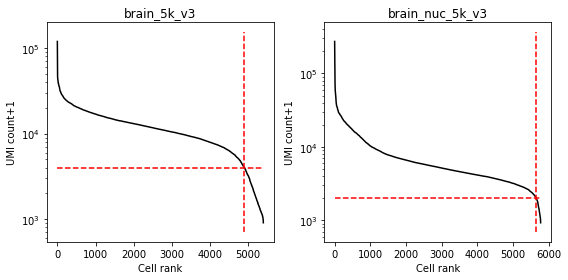

In [14]:
cf = []
thr_lb = [4e3, 2e3]
thr_ub = [5e4, 5e4]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
        ax1[k].set_title(dataset_meta[k])        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        S_arr.append(S)
        U_arr.append(U)
        cf.append(cf_)
fig1.tight_layout()

In [15]:
[x.sum() for x in cf]

[4900, 5619]

## Sc/sn comparison

In [16]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=False):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))

/tmp/ipykernel_739201/1943922227.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


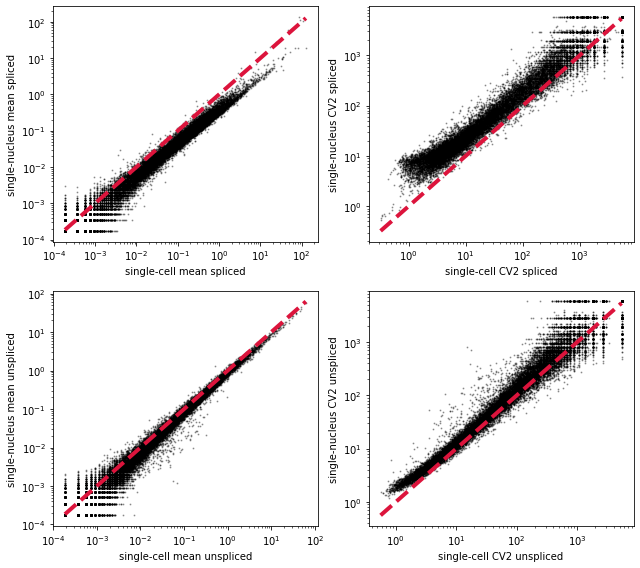

In [17]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'CV2',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()


/tmp/ipykernel_739201/680583236.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)


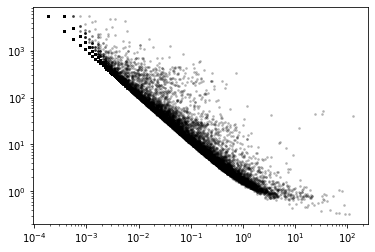

In [18]:
plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_739201/2533449854.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)


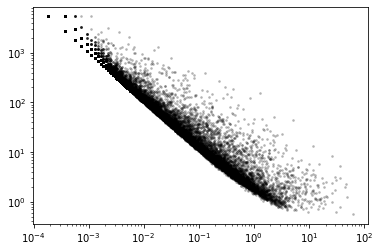

In [19]:
plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_436754/1752493799.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


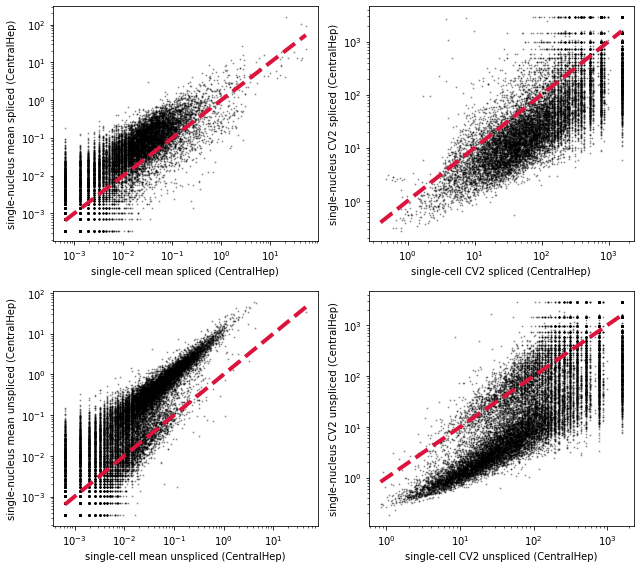

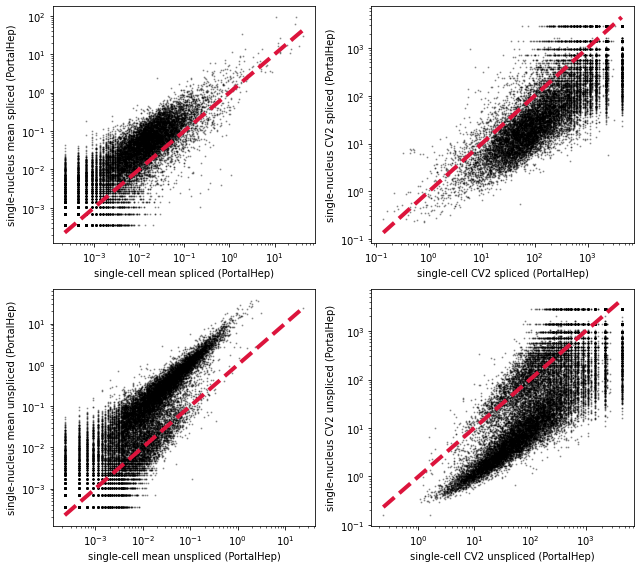

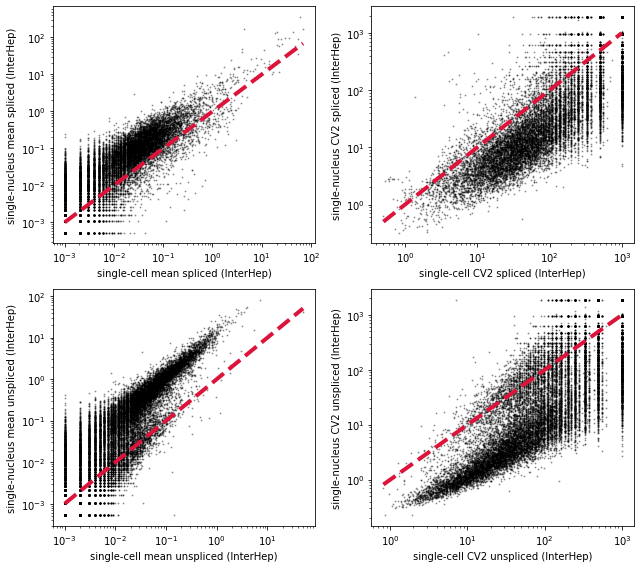

In [62]:
for k in range(3):
    fig1,ax1 = plt.subplots(2,2,figsize=(9,8))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[0][0],'spliced ({})'.format(cluster_names[k]))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[0][1],'spliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[1][0],'unspliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[1][1],'unspliced ({})'.format(cluster_names[k]))
    fig1.tight_layout()


## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [20]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [21]:
transcriptome_filepath

'../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1 created.
INFO:root:Dataset: brain_5k_v3
INFO:root:4900 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5212 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3 created.
INFO:root:Dataset: brain_nuc_5k_v3
INFO:root:5619 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4668 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3 created.
INFO:root:Total of 3000 genes selected.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/diagnostic_figures created.


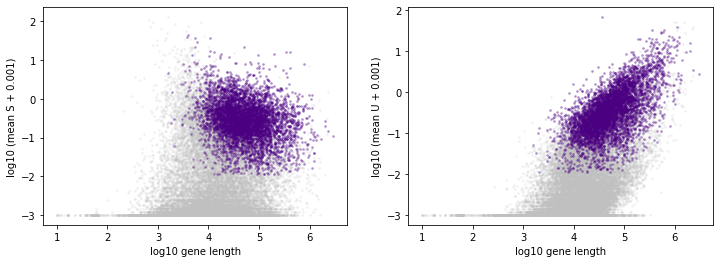

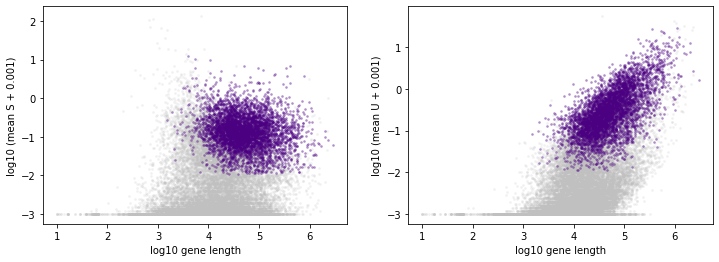

In [22]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='brain_nuc',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

## Inference

In [23]:
dir_string

'./fits/gg_221209_025_brain_nuc_1'

In [24]:
dataset_strings

['./fits/gg_221209_025_brain_nuc_1/brain_5k_v3',
 './fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3']

Define parameter bounds, then iterate over datasets and perform the fits.

In [25]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]

gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}

INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_5k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221209_025_brain_nuc_1/genes.csv.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [44:34<00:00,  6.37s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 2677.6 seconds.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_nuc_5k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221209_025_brain_nuc_1/genes.csv.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [51:42<00:00,  7.39s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 3104.8 seconds.


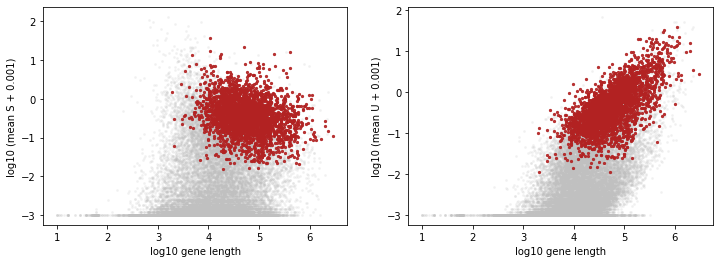

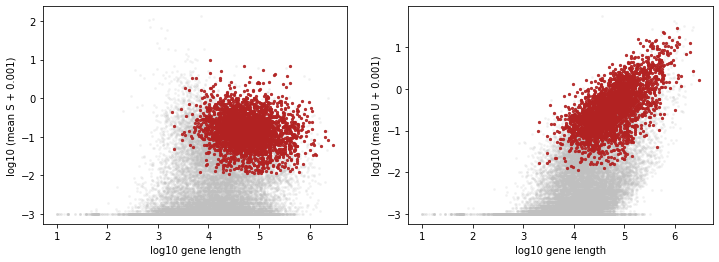

In [26]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(60,search_data)
    result_strings.append(full_result_string)

## Post-processing

INFO:root:Grid scan results loaded from ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 56 genes out of 3000. Runtime: 8.2 seconds.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.11, -0.75.
INFO:root:Chi-square computation complete. Rejected 56 genes out of

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 65 genes out of 3000. Runtime: 6.9 seconds.
INFO:root:

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221209_025_brain_nuc_1/analysis_figures already exists.


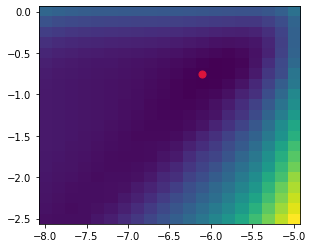

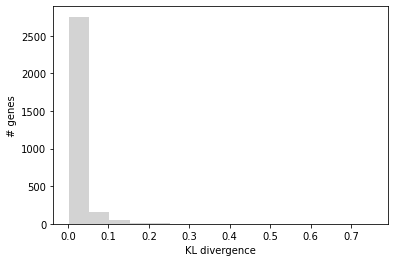

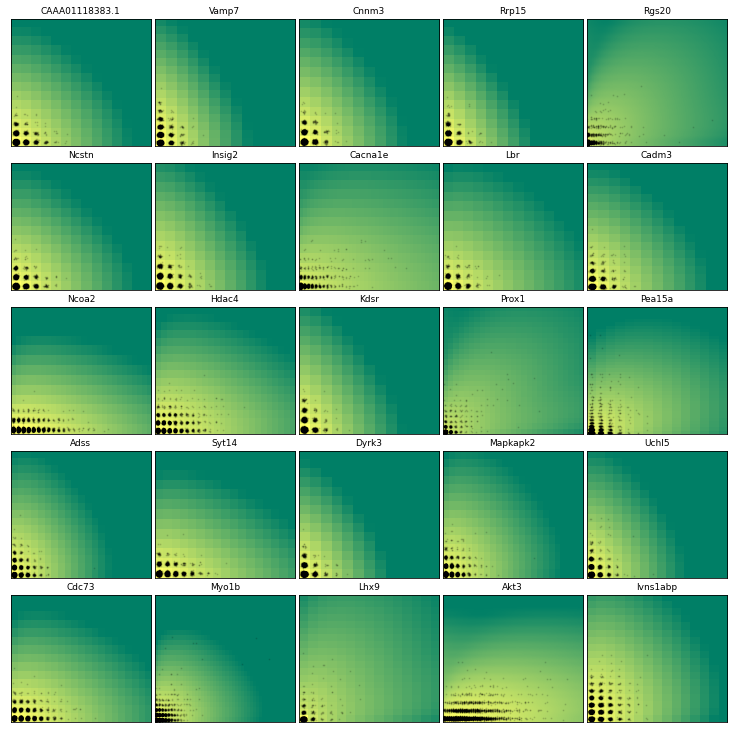

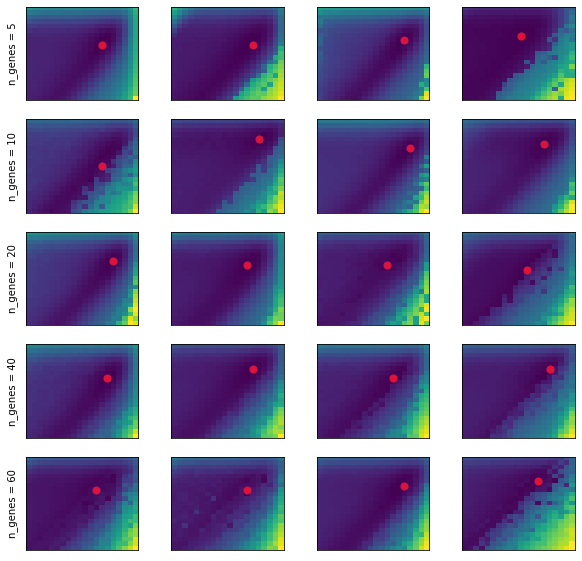

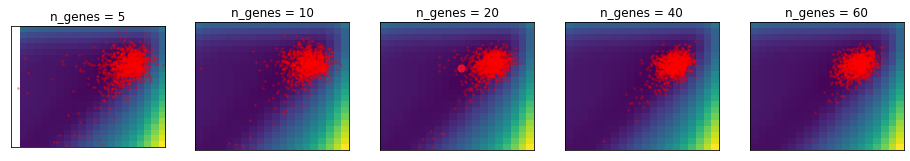

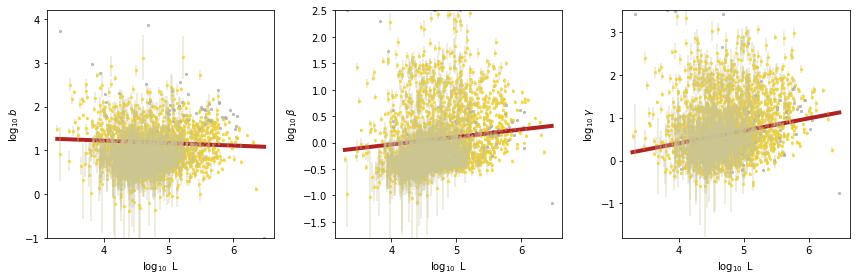

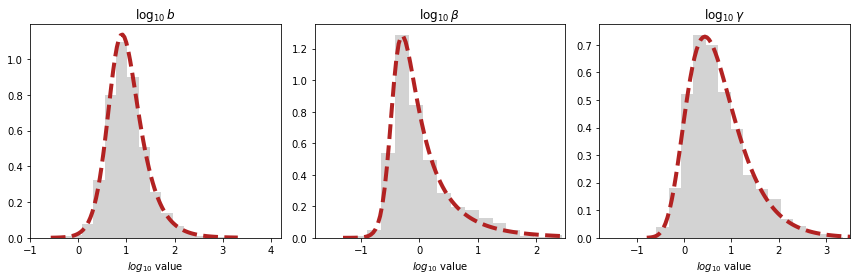

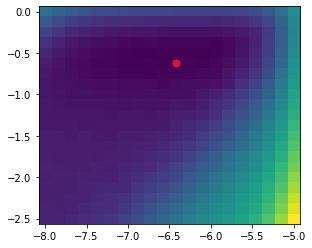

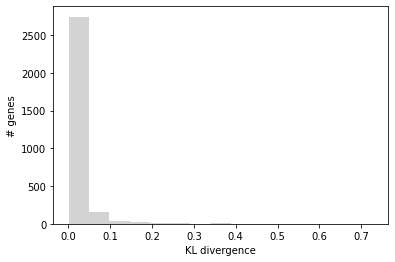

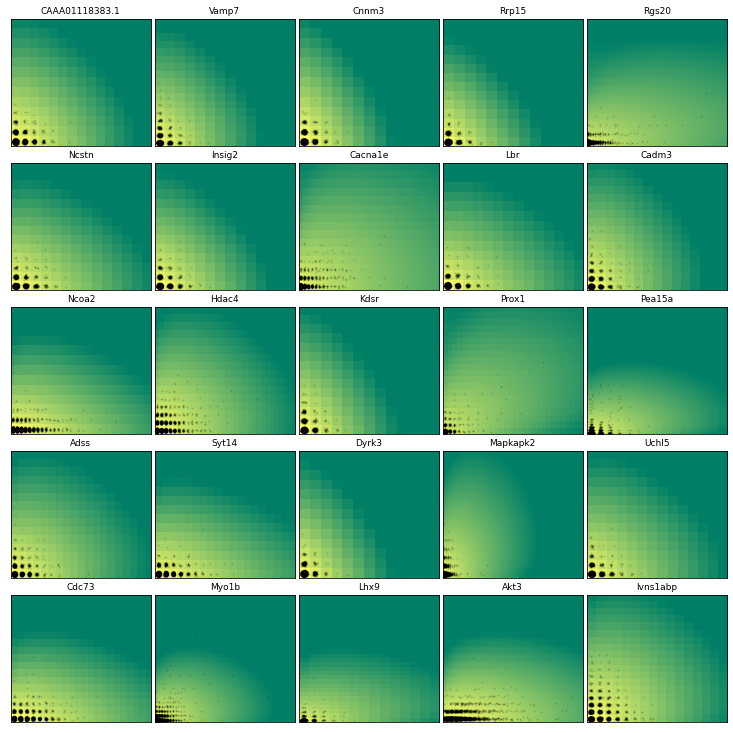

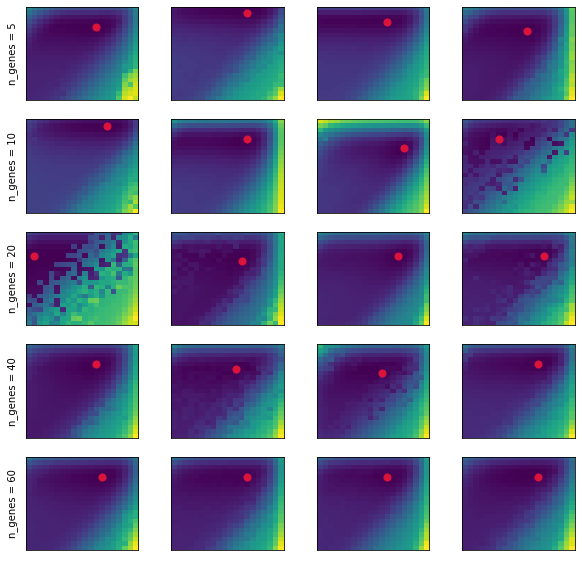

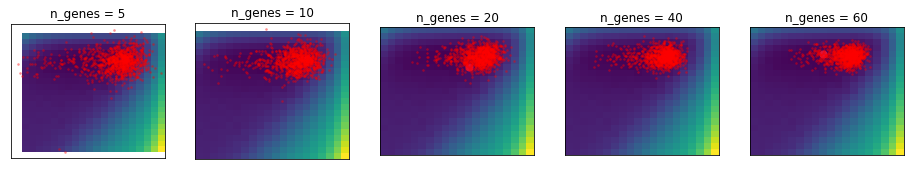

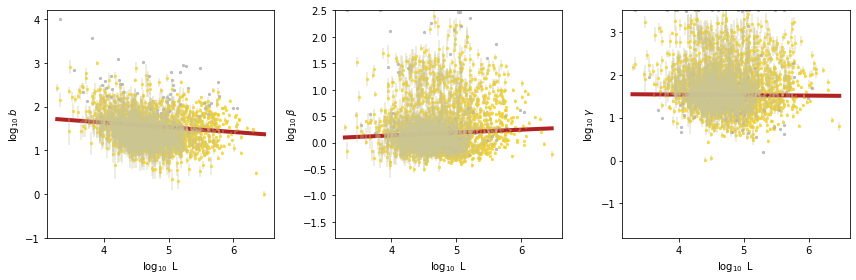

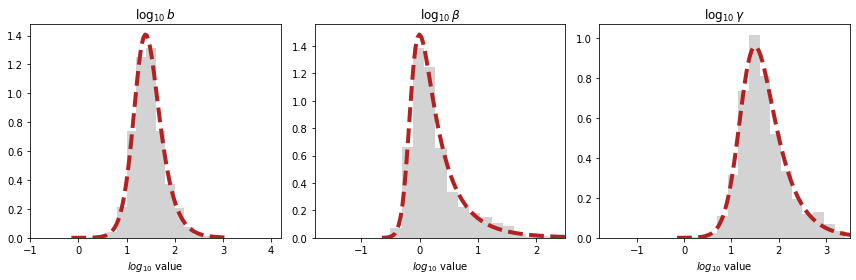

In [27]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


## Analysis

In [148]:
dir_string = './fits/gg_221209_025_brain_nuc_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [149]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Grid scan results loaded from ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_221209_025_brain_nuc_1/brain_5k_v3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_221209_025_brain_nuc_1/brain_nuc_5k_v3/raw.sd.


Offset: -0.42
Offset: -0.11


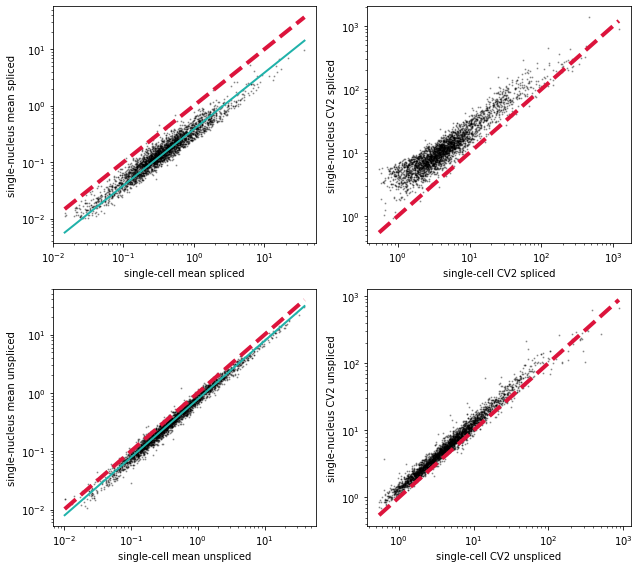

In [150]:
# for k in range(3):
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(sd_arr[0].layers[1],
          sd_arr[1].layers[1],
          'mean',ax1[0][0],'spliced',True)
plot_stat(sd_arr[0].layers[1],
          sd_arr[1].layers[1],
          'CV2',ax1[0][1],'spliced')
plot_stat(sd_arr[0].layers[0],
          sd_arr[1].layers[0],
          'mean',ax1[1][0],'unspliced',True)
plot_stat(sd_arr[0].layers[0],
          sd_arr[1].layers[0],
          'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()

In [110]:
# arbitrary_v2_params = np.asarray([-7,-2])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# print(sr_arr[0].sp.sampl_vals[arbitrary_v2_ind])

In [111]:
# samp_lb

In [112]:
# samp_ub

sc: -5.95, -1.12
sn: -5.79, -0.88


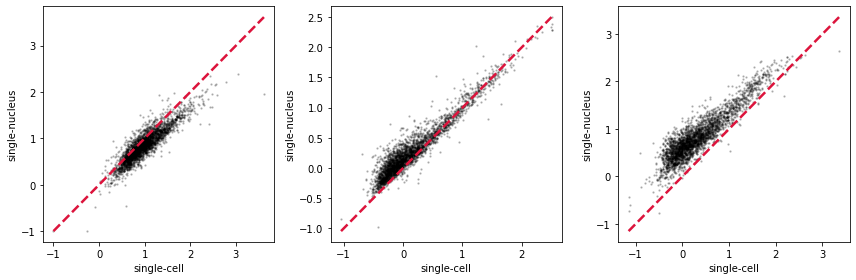

In [115]:
# for k in range(3):
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))

arbitrary_v3_params = np.asarray([-5.8,-0.9])
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)

# total_divg = ((sr_arr[0].param_estimates[:,~sr_arr[1].rejected_genes,:2] 
#                         - sr_arr[1].phys_optimum[~sr_arr[1].rejected_genes,:2])**2).sum((1,2))
# arbitrary_v2_ind = np.argmin(total_divg)
arbitrary_v3_params -= 0.2
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[0].set_sampling_optimum(arbitrary_v3_ind)
# sr_arr[0].set_sampling_optimum(arbitrary_v2_ind)

print('sc: {:.2f}, {:.2f}'.format(*sr_arr[0].samp_optimum))

print('sn: {:.2f}, {:.2f}'.format(*sr_arr[1].samp_optimum))
for j in range(3):
    x = sr_arr[0].phys_optimum[~sr_arr[k].rejected_genes,j]
    y = sr_arr[1].phys_optimum[~sr_arr[k].rejected_genes,j]
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('single-cell')
    ax1[j].set_ylabel('single-nucleus')
fig1.tight_layout()

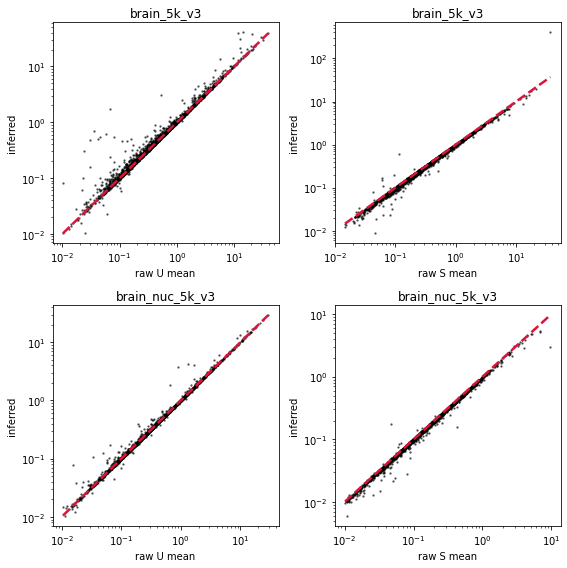

In [157]:
# arbitrary_v3_params = np.asarray([-6.5,0])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)
fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

k=0
for j in range(2):
    physopts = 10**sr_arr[k+j].phys_optimum
    sampopts = 10**sr_arr[k+j].regressor_optimum
    
    x = sd_arr[k+j].layers[0].mean(1)
    y = sampopts[:,0]*physopts[:,0]/physopts[:,1]
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('raw U mean')
    ax1[j,0].set_ylabel('inferred')
    
    x = sd_arr[k+j].layers[1].mean(1)
    y = sampopts[:,1]*physopts[:,0]/physopts[:,2]
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('raw S mean')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

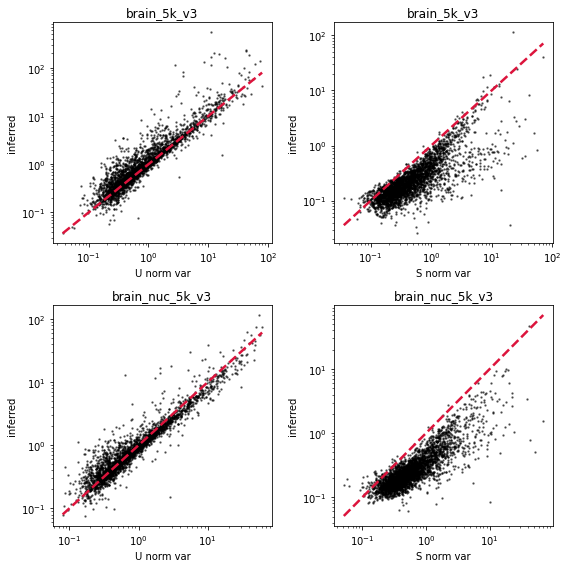

In [158]:
k=0

# arbitrary_v2_params = np.asarray([-8,-2.5])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

# arbitrary_v3_params = np.asarray([-6.2,-1.5])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

for j in range(2):
    
    physopts = 10**sr_arr[k+j].phys_optimum
    sampopts = 10**sr_arr[k+j].regressor_optimum
    
    x = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    y = sampopts[:,0] * (1 + physopts[:,0])
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('U norm var')
    ax1[j,0].set_ylabel('inferred')
    
    x = (sd_arr[k+j].layers[1].var(1))/(sd_arr[k+j].layers[1].mean(1))-1
    y = sampopts[:,1] * (1 + physopts[:,0] * physopts[:,1]/(physopts[:,1] + physopts[:,2]))
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('S norm var')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

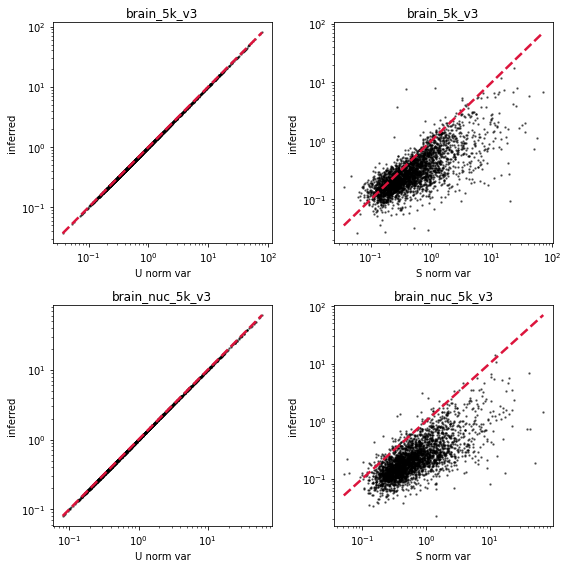

In [147]:
k=0

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

for j in range(2):
    
    physopts = 10**sr_arr[k+j].phys_optimum
#     sampopts = 10**sr_arr[k+j].regressor_optimum
    b = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    beta = b/sd_arr[k+j].layers[0].mean(1)
    gamma = b/sd_arr[k+j].layers[1].mean(1)
    
    x = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    y = b
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('U norm var')
    ax1[j,0].set_ylabel('inferred')
    
    x = (sd_arr[k+j].layers[1].var(1))/(sd_arr[k+j].layers[1].mean(1))-1
    y = b*beta/(beta+gamma)
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('S norm var')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

In [86]:
sd_arr[0]

In [47]:
sr_arr[k].samp_optimum

(-5.7894736842105265, -1.25)

In [48]:
sr_arr[0].regressor_optimum

array([[-1.48191347, -1.25      ],
       [-1.33598716, -1.25      ],
       [-1.57539848, -1.25      ],
       ...,
       [-1.37686196, -1.25      ],
       [-1.52690395, -1.25      ],
       [-1.28803099, -1.25      ]])

In [49]:
dataset_names

['brain_5k_v3', 'brain_nuc_5k_v3']

In [50]:
# k

In [153]:
from matplotlib.colors import ListedColormap
c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


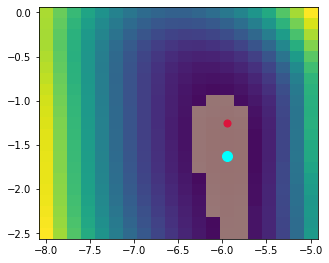

In [154]:
k=0

arbitrary_v3_params = np.asarray([-6,-1.2])
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[k+1].set_sampling_optimum(arbitrary_v3_ind)

total_divg = ((sr_arr[k].param_estimates[:,~sr_arr[k+1].rejected_genes,:2] 
                        - sr_arr[k+1].phys_optimum[~sr_arr[k+1].rejected_genes,:2])**2).sum((1,2))

arbitrary_v2_ind = np.argmin(total_divg)
sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,1,figsize=(5,5))
dx = (np.asarray(sr_arr[0].sp.samp_ub) - np.asarray(sr_arr[0].sp.samp_lb)) / (
    np.asarray(sr_arr[0].sp.gridsize) - 1
)
dx[dx < 1e-10] = 0.1
extent = [
    sr_arr[0].sp.samp_lb[0] - dx[0] / 2,
    sr_arr[0].sp.samp_ub[0] + dx[0] / 2,
    sr_arr[0].sp.samp_lb[1] - dx[1] / 2,
    sr_arr[0].sp.samp_ub[1] + dx[1] / 2,
]
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg, sr_arr[0].sp.gridsize).T), extent=extent
)

q = np.quantile(total_divg,0.1)
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg>q, sr.sp.gridsize).T), extent=extent,
    cmap = cmap_highlight_landscape,alpha=0.5
)

ax1.scatter(sr_arr[k+1].samp_optimum[0], sr_arr[k+1].samp_optimum[1], c="crimson", s=50)

ax1.scatter(sr_arr[k].samp_optimum[0], sr_arr[k].samp_optimum[1], c="cyan", s=100)

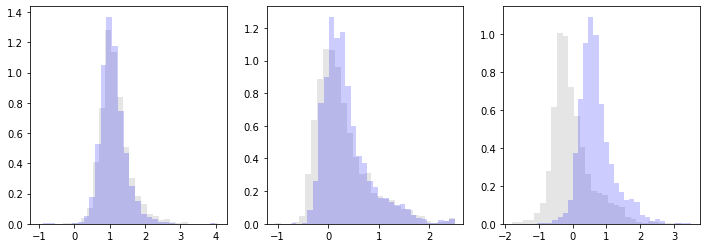

In [155]:

# for k in range(3):


#     arbitrary_v3_params = np.asarray([-6,-1])
#     arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
#     sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

#     arbitrary_v2_params = np.asarray([-6.7,-3])
#     arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
#     sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*1+['b']*1
for j in range(3):
    for k,sr in enumerate(sr_arr):
        ax1[j].hist(sr.phys_optimum[:,j],30,alpha=0.2,color=colors[k],density=True)

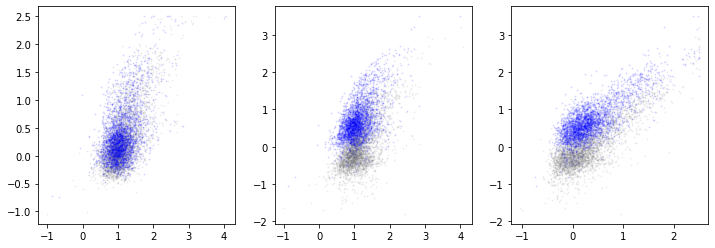

In [156]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*1+['b']*1
for j,pair in enumerate([[0,1],[0,2],[1,2]]):
    for k,sr in enumerate(sr_arr):
        ax1[j].scatter(sr.phys_optimum[:,pair[0]],sr.phys_optimum[:,pair[1]],1,alpha=0.1,c=colors[k])

In [139]:
sd=sd_arr[0]

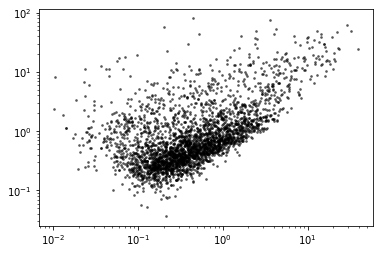

In [140]:
means = sd.layers[0].mean(1)
Fanos = sd.layers[0].var(1)/means-1
plt.scatter(means,Fanos,3,'k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')

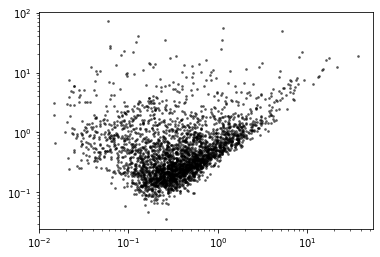

In [141]:
means = sd.layers[1].mean(1)
Fanos = sd.layers[1].var(1)/means-1
plt.scatter(means,Fanos,3,'k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')

Let's go back and see if I allowed serious issues to slip in BR.

In [299]:
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]


In [345]:
batch = 3
k=3
sr = monod.analysis.load_search_results('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sd = monod.analysis.load_search_data('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/raw.sd')


physopts  = 10**sr.phys_optimum

INFO:root:Grid scan results loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_H12/raw.sd.


In [346]:
sampopts = 10**sr.regressor_optimum

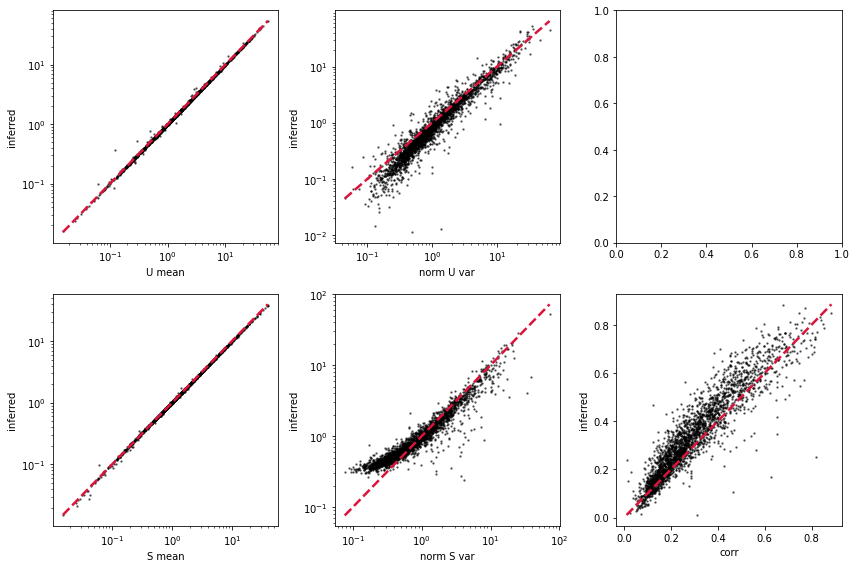

In [351]:

fig1,ax1 = plt.subplots(2,3,figsize=(12,8))


x = sd.layers[0].mean(1)
y = sampopts[:,0] * physopts[:,0]/physopts[:,1]
ax1[0,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('U mean')
ax1[0,0].set_ylabel('inferred')

x = sd.layers[1].mean(1)
y = sampopts[:,1] * physopts[:,0]/physopts[:,2]
ax1[1,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,0].set_xscale('log')
ax1[1,0].set_yscale('log')
ax1[1,0].set_xlabel('S mean')
ax1[1,0].set_ylabel('inferred')


x = sd.layers[0].var(1)/sd.layers[0].mean(1) - 1
y = sampopts[:,0] * (1+physopts[:,0])
ax1[0,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,1].set_xscale('log')
ax1[0,1].set_yscale('log')
ax1[0,1].set_xlabel('norm U var')
ax1[0,1].set_ylabel('inferred')

F = physopts[:,1]/(physopts[:,1] + physopts[:,2])

x = sd.layers[1].var(1)/sd.layers[1].mean(1) - 1
y = sampopts[:,1] * (1+physopts[:,0] * F)
ax1[1,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,1].set_xscale('log')
ax1[1,1].set_yscale('log')
ax1[1,1].set_xlabel('norm S var')
ax1[1,1].set_ylabel('inferred')

x = np.asarray([np.corrcoef(x)[0][1] for x in zip(sd.layers[0],sd.layers[1])])
b = physopts[:,0] 
y = np.sqrt(b**2 * F*(1-F) * sampopts[:,0] * sampopts[:,1] /((1+sampopts[:,0]*(1+b))*(1+sampopts[:,1]*(1+b*F))))
ax1[1,2].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,2].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[1,2].set_xscale('log')
# ax1[1,2].set_yscale('log')
ax1[1,2].set_xlabel('corr')
ax1[1,2].set_ylabel('inferred')
fig1.tight_layout()

Meh. Not so much.